# LAB SQL 9

We will be trying to predict if a customer will be renting a film this month based on their previous activity and other details. We will first construct a table with:

In [39]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [40]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [41]:
result = engine.execute('SELECT * FROM film')
for row in result:
    print(row)
rows = [row for row in result]
pd.DataFrame(rows)

(1, 'ACADEMY DINOSAUR', 'A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies', 2006, 1, None, 6, Decimal('0.99'), 86, Decimal('20.99'), 'PG', 'Deleted Scenes,Behind the Scenes', datetime.datetime(2006, 2, 15, 5, 3, 42))
(2, 'ACE GOLDFINGER', 'A Astounding Epistle of a Database Administrator And a Explorer who must Find a Car in Ancient China', 2006, 1, None, 3, Decimal('4.99'), 48, Decimal('12.99'), 'G', 'Trailers,Deleted Scenes', datetime.datetime(2006, 2, 15, 5, 3, 42))
(3, 'ADAPTATION HOLES', 'A Astounding Reflection of a Lumberjack And a Car who must Sink a Lumberjack in A Baloon Factory', 2006, 1, None, 7, Decimal('2.99'), 50, Decimal('18.99'), 'NC-17', 'Trailers,Deleted Scenes', datetime.datetime(2006, 2, 15, 5, 3, 42))
(4, 'AFFAIR PREJUDICE', 'A Fanciful Documentary of a Frisbee And a Lumberjack who must Chase a Monkey in A Shark Tank', 2006, 1, None, 5, Decimal('2.99'), 117, Decimal('26.99'), 'G', 'Commentaries,Behind the Scenes', da

""


In [42]:
data = pd.read_sql_query('SELECT * FROM film', engine)
data.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42


In [43]:
engine.execute("USE sakila")

In [44]:
# Customer ID and City

query = 'select customer.customer_id, city.city \
from customer, city, address \
where city.city_id=address.city_id \
and customer.address_id=address.address_id'
customer_city = pd.read_sql_query(query, engine)
customer_city.head()

,customer_id,city
0,1,Sasebo
1,2,San Bernardino
2,3,Athenai
3,4,Myingyan
4,5,Nantou


In [45]:
customer_city.shape

(599, 2)

In [7]:
# Total films rented

query = 'select rental.customer_id, count(inventory.film_id) as total_films_rented \
from rental, inventory \
where rental.inventory_id=inventory.inventory_id \
group by rental.customer_id \
order by rental.customer_id asc'
film_rent = pd.read_sql_query(query, engine)
film_rent.head()

,customer_id,total_films_rented
0,1,32
1,2,27
2,3,26
3,4,22
4,5,38


In [46]:
film_rent.shape

(599, 2)

In [8]:
# Total money spent

query = 'select payment.customer_id, sum(payment.amount) as total_money_spent \
from payment \
group by payment.customer_id \
order by payment.customer_id asc'
money_spent = pd.read_sql_query(query, engine)
money_spent.head()

,customer_id,total_money_spent
0,1,118.68
1,2,128.73
2,3,135.74
3,4,81.78
4,5,144.62


In [47]:
money_spent.shape

(599, 2)

In [48]:
# Most rented film category

query = 'SELECT customer as "customer_id", Category_name FROM \
(SELECT rental.customer_id as customer, count(rental.rental_id) as total_rentals, film_category.category_id, category.name as Category_name, \
row_number() over (partition by rental.customer_id order by count(rental.rental_id) desc) as ranking_max_rented_category \
FROM rental \
INNER JOIN inventory ON rental.inventory_id = inventory.inventory_id \
INNER JOIN film_category ON inventory.film_id = film_category.film_id \
INNER JOIN category ON film_category.category_id = category.category_id \
GROUP BY rental.customer_id, film_category.category_id, category.name) AS table_popular_category \
WHERE ranking_max_rented_category = 1 \
ORDER BY customer;' 

most_cat = pd.read_sql_query(query, engine)
most_cat.head()

,customer_id,Category_name
0,1,Classics
1,2,Sports
2,3,Action
3,4,Horror
4,5,Classics


In [49]:
most_cat.shape

(599, 2)

In [52]:
# Rented last month
# with YES NO VALUE

query = 'SELECT customer_id, \
case \
    when count(rental_id) > 0 then "Yes" \
    else "No" \
end as "Rented last month" \
FROM sakila.rental \
where rental_date >= 20050601 and rental_date <= 20050615 \
group by customer_id \
ORDER BY customer_id;'
total_rent = pd.read_sql_query(query, engine)
total_rent.head()

,customer_id,Rented last month
0,46,Yes
1,49,Yes
2,139,Yes
3,191,Yes
4,239,Yes


In [53]:
total_rent.shape

(16, 2)

In [54]:
# And try to predict if he will be renting this month 
# with YES NO VALUE

query = 'SELECT customer_id, \
case \
    when count(rental_id) > 0 then "Yes" \
    else "No" \
end as "Rented this month" \
FROM sakila.rental \
where rental_date >= 20050601 and rental_date <= 20050615 \
group by customer_id \
ORDER BY customer_id;'
total_rent2 = pd.read_sql_query(query, engine)
total_rent2.head()

,customer_id,Rented this month
0,46,Yes
1,49,Yes
2,139,Yes
3,191,Yes
4,239,Yes


In [55]:
# Concat 

import functools 

data_frames = [customer_city, film_rent, money_spent, most_cat, total_rent, total_rent2]
data_merge = functools.reduce(lambda  left,right: pd.merge(left,right,on=['customer_id'], how='outer'), data_frames).fillna('N')
data_merge

,customer_id,city,total_films_rented,total_money_spent,Category_name,Rented last month,Rented this month
0,1,Sasebo,32,118.68,Classics,N,N
1,2,San Bernardino,27,128.73,Sports,N,N
2,3,Athenai,26,135.74,Action,N,N
3,4,Myingyan,22,81.78,Horror,N,N
4,5,Nantou,38,144.62,Classics,N,N
...,...,...,...,...,...,...,...
594,595,Jinzhou,30,117.70,Documentary,Yes,Yes
595,596,Patras,28,96.72,Sports,N,N
596,597,Sullana,25,99.75,Foreign,N,N
597,598,Lausanne,22,83.78,Drama,N,N


In [56]:
data_merge.describe()

,customer_id,total_films_rented,total_money_spent
count,599.000000,599.000000,599.000000
mean,300.000000,26.786311,112.548431
std,173.060683,5.109609,25.370360
min,1.000000,12.000000,50.850000
25%,150.500000,23.000000,94.785000
50%,300.000000,26.000000,110.730000
75%,449.500000,30.000000,128.705000
max,599.000000,46.000000,221.550000


In [57]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         599 non-null    int64  
 1   city                599 non-null    object 
 2   total_films_rented  599 non-null    int64  
 3   total_money_spent   599 non-null    float64
 4   Category_name       599 non-null    object 
 5   Rented last month   599 non-null    object 
 6   Rented this month   599 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 37.4+ KB


In [58]:
#Data exploration

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

In [61]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         599 non-null    int64  
 1   city                599 non-null    object 
 2   total_films_rented  599 non-null    int64  
 3   total_money_spent   599 non-null    float64
 4   Category_name       599 non-null    object 
 5   Rented last month   599 non-null    object 
 6   Rented this month   599 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 37.4+ KB


In [77]:
# Change Customer ID to object

data_merge['customer_id'] = data_merge['customer_id'].astype('str')
data_merge['customer_id'] = data_merge['customer_id'].astype('object')

# Verification

data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         599 non-null    object 
 1   city                599 non-null    object 
 2   total_films_rented  599 non-null    int64  
 3   total_money_spent   599 non-null    float64
 4   Category_name       599 non-null    object 
 5   Rented last month   599 non-null    object 
 6   Rented this month   599 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 37.4+ KB


In [68]:
data_merge['city'] = data_merge['city'].astype('str')
data_merge['Category_name'] = data_merge['Category_name'].astype('str')
data_merge['Rented last month'] = data_merge['Rented last month'].astype('str')
data_merge['Rented this month'] = data_merge['Rented this month'].astype('str')

In [69]:
data_merge.describe()

,total_films_rented,total_money_spent
count,599.000000,599.000000
mean,26.786311,112.548431
std,5.109609,25.370360
min,12.000000,50.850000
25%,23.000000,94.785000
50%,26.000000,110.730000
75%,30.000000,128.705000
max,46.000000,221.550000


In [70]:
print(data_merge.isna().sum())
# No NA values

customer_id           0
city                  0
total_films_rented    0
total_money_spent     0
Category_name         0
Rented last month     0
Rented this month     0
dtype: int64


In [79]:
display(data_merge)

,customer_id,city,total_films_rented,total_money_spent,Category_name,Rented last month,Rented this month
0,1,Sasebo,32,118.68,Classics,N,N
1,2,San Bernardino,27,128.73,Sports,N,N
2,3,Athenai,26,135.74,Action,N,N
3,4,Myingyan,22,81.78,Horror,N,N
4,5,Nantou,38,144.62,Classics,N,N
...,...,...,...,...,...,...,...
594,595,Jinzhou,30,117.70,Documentary,Yes,Yes
595,596,Patras,28,96.72,Sports,N,N
596,597,Sullana,25,99.75,Foreign,N,N
597,598,Lausanne,22,83.78,Drama,N,N


In [82]:
data=data_merge

In [86]:
# Dummy
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['customer_id'], axis=1)
categorical = pd.get_dummies(cat, columns=['city','Category_name', 'Rented last month', 'Rented this month'],drop_first=True)
categorical.head()

,city_Abha,city_Abu Dhabi,city_Acua,city_Adana,city_Addis Abeba,city_Aden,city_Adoni,city_Ahmadnagar,city_Akishima,city_Akron,...,Category_name_Foreign,Category_name_Games,Category_name_Horror,Category_name_Music,Category_name_New,Category_name_Sci-Fi,Category_name_Sports,Category_name_Travel,Rented last month_Yes,Rented this month_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


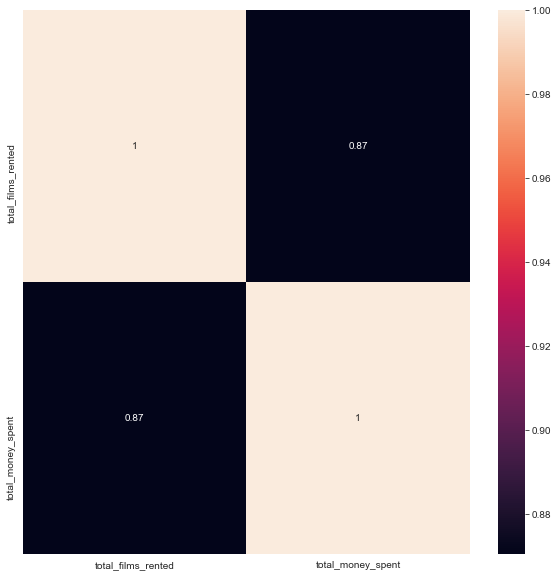

In [87]:
# Numerical columns

# Correlation
corr_matrix=data.corr(method='pearson') # default
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

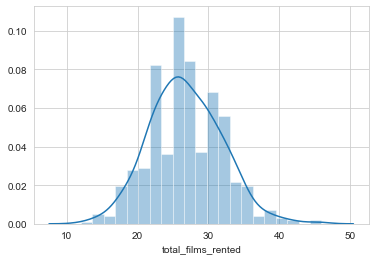

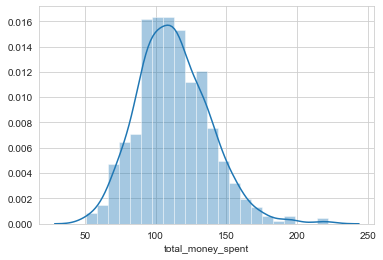

In [88]:
# Distribution

sns.distplot(concat['total_films_rented'])
plt.show()

sns.distplot(concat['total_money_spent'])
plt.show()

In [89]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

X = data.select_dtypes(include = np.number)

X1 = X.copy()
X2 = X.copy()

In [90]:
# Normalizer
transformer = Normalizer().fit(X1)
x_normalized = transformer.transform(X1)
x_normalized = pd.DataFrame(x_normalized)

In [91]:
# Standardizer
transformer = StandardScaler().fit(X2)
x_standarized = transformer.transform(X2)
x_standarized = pd.DataFrame(x_standarized)

In [92]:
y = data['Rented last month']
x = np.concatenate((x_normalized, categorical), axis=1)

In [94]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=100)

In [95]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=250)

In [96]:
from sklearn.metrics import accuracy_score

predictions = classification.predict(X_test)

The accuracy of the model on test set is: 0.98 
[[235   0]
 [  5   0]]


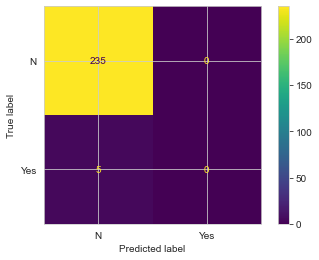

The Kappa of your model is: 0.00


In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))